### Deriving Greeks from option spreads
Imports data from `adjusted_options` although raw data works fine as well

In [6]:
import datetime
import os
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm import tqdm

if os.getcwd()[-3:] == "src":
    os.chdir(os.path.dirname(os.getcwd()))
else:
    pass

**User defined parameters**

In [7]:
stock_of_interest = "AAPL"
option_data_path = "data/adjusted_options/"
default_save_path = "data/adjusted_options/"

**Load adjusted options data**

In [8]:
try:
    options_df = pd.read_csv(os.path.abspath(os.path.join(option_data_path, (stock_of_interest + ".csv"))))
    options_df["date"] = pd.to_datetime(options_df["date"]).dt.date
    options_df["expiration date"] = pd.to_datetime(options_df["expiration date"]).dt.date
except FileNotFoundError:
    raise SystemExit("Option data for " + stock_of_interest + " not found in path: " +
                     os.path.abspath(os.path.join(option_data_path, stock_of_interest)) + ".csv")

In [9]:
call_options = options_df[options_df["type"] == "call"]


Delta ($\Delta$) at a certain strike price (K) is calculated based off the forward and backward change in strike price. For example, for K=20, the delta at K=19.5 is calculated by taking the slope between K=19 and K=20. Likewise, Delta at K=20.5 is based off ask/bid prices at K=20 and K=21.

Note that the assumption of midpoint is built upon the existence of a monotonic Delta function, which is realistic. For example, the Delta of long calls should decrease from 1 (very ITM) to 0 (very OTM).

In [14]:
dates = set(call_options["date"])
delta_df = pd.DataFrame()
gamma_df = pd.DataFrame()

for my_day in tqdm(dates):
    day_options = call_options[call_options["date"] == my_day]
    exp_dates = set(day_options["expiration date"])
    for exp_day in exp_dates:
        exp_day_options = day_options[day_options["expiration date"] == exp_day]
        # Calculating Delta
        temp_delta_df = exp_day_options[["strike price", "ask price", "bid price"]].diff()[1:].reset_index(drop=True)
        temp_delta_df = temp_delta_df.rename(columns={"strike price": "asset change",
                                                      "ask price": "ask change",
                                                      "bid price": "bid change"})
        # Change in asset price is negative of change in strike price
        temp_delta_df["asset change"] = -temp_delta_df["asset change"]
        # Strike price for delta to be midpoint between the two options
        temp_delta_df["strike price"] = (exp_day_options["strike price"][:-1].reset_index(drop=True) +
                                         exp_day_options["strike price"][1:].reset_index(drop=True)) / 2
        temp_delta_df["ask"] = temp_delta_df["ask change"] / (temp_delta_df["asset change"])
        temp_delta_df["bid"] = temp_delta_df["bid change"] / (temp_delta_df["asset change"])
        temp_delta_df[["date", "expiration date"]] = [my_day, exp_day]
        # Calculating Gamma
        temp_gamma_df = temp_delta_df[["strike price", "ask", "bid"]].diff()[1:].reset_index(
            drop=True)
        temp_gamma_df = temp_gamma_df.rename(columns={"strike price": "asset change",
                                                      "ask": "ask delta change",
                                                      "bid": "bid delta change"})
        temp_gamma_df["asset change"] = -temp_gamma_df["asset change"]
        temp_gamma_df["strike price"] = (temp_delta_df["strike price"][:-1].reset_index(drop=True) +
                                         temp_delta_df["strike price"][1:].reset_index(drop=True)) / 2
        temp_gamma_df["ask"] = temp_gamma_df["ask delta change"] / temp_gamma_df["asset change"]
        temp_gamma_df["bid"] = temp_gamma_df["bid delta change"] / temp_gamma_df["asset change"]
        temp_gamma_df[["date", "expiration date"]] = [my_day, exp_day]
        # Append to respective DataFrames
        delta_df = delta_df.append(temp_delta_df, ignore_index=True)
        gamma_df = gamma_df.append(temp_gamma_df, ignore_index=True)

# Sort since set randomizes dates
delta_df = delta_df.sort_values(by=["date", "expiration date", "strike price"]).reset_index(drop=True)
gamma_df = gamma_df.sort_values(by=["date", "expiration date", "strike price"]).reset_index(drop=True)

100%|██████████| 252/252 [00:28<00:00,  8.93it/s]


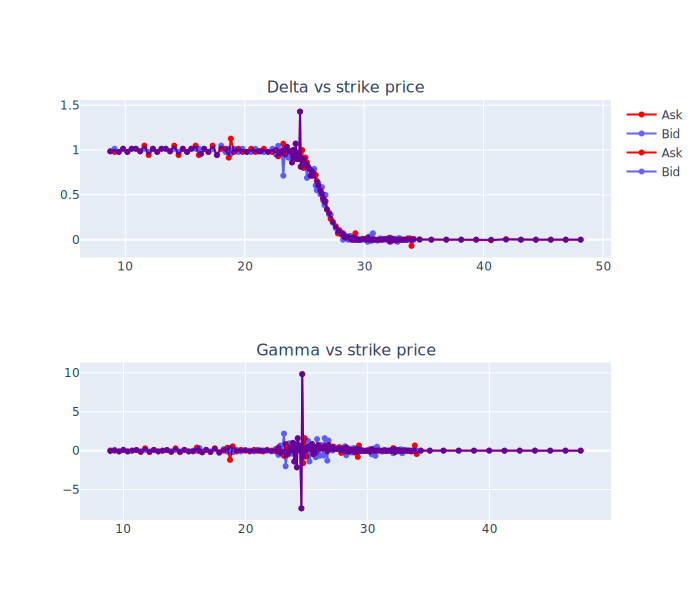

In [35]:
plot_date = datetime.date(2016, 1, 4)
plot_exp_date = datetime.date(2016, 1, 15)

temp_delta_df = delta_df[(delta_df["date"] == plot_date) &
                         (delta_df["expiration date"] == plot_exp_date)]

temp_gamma_df = gamma_df[(gamma_df["date"] == plot_date) &
                         (gamma_df["expiration date"] == plot_exp_date)]

if not temp_delta_df.shape[0]:
    raise Exception("Date and/or expiration date combo not valid!")

dg_fig = make_subplots(rows=2, cols=1,
                       subplot_titles=["Delta vs strike price", "Gamma vs strike price"])

for n in [temp_delta_df, temp_gamma_df]:
    if n.shape[0] == temp_delta_df.shape[0]:
        nrow = 1
    else:
        nrow = 2

    dg_fig.add_trace(go.Scatter(x=n["strike price"],
                                y=n["ask"],
                                mode='lines+markers',
                                opacity=1,
                                marker_color="red",
                                name="Ask"),
                     row=nrow, col=1)

    dg_fig.add_trace(go.Scatter(x=n["strike price"],
                                y=n["bid"],
                                mode='lines+markers',
                                opacity=0.6,
                                marker_color="blue",
                                name="Bid"),
                     row=nrow, col=1)

dg_fig.show("svg", width=700, height=600)
